<a href="https://colab.research.google.com/github/Dagobert42/WinProbabilityModel-AoE2/blob/main/WinProbabilityModel_AoE2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Non-Linear Win Probability Model for Age of Empires II

- Age of Empires II ["AoE2"] is a real-time strategy game set in the middle-ages
- players build a base and command units with the goal of defeating each other 

**Hypothesis:** map and civilisation have non-linear influence on the initial win probabilities of a match

**Idea:** compare predictive power of linear and non-linear models

This project conforms to Microsoft's [Game Content Usage Rules](https://www.xbox.com/en-us/developers/rules).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

## 1. Introduction

- players are rated in Elo-system (similar to Chess)
- ratings can be converted directly into probability distributions for the outcome of a match between players A and B by:

$$wp_{A} = \frac{1}{1+10 ^{(r_{A} - r_{B}) / t)}}$$

TODO: cite wikipedia

In [3]:
TRANSFER = 200
def elo_to_win_prob(r_player, r_opponent):
    return 1 / ( 1 + 10**((r_opponent - r_player) / TRANSFER))

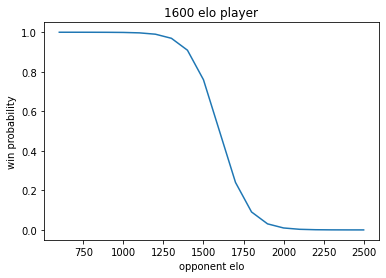

In [4]:
player = 1600
opponents = range(600, 2600, 100)
probs = []
for o in opponents:
    probs.append(elo_to_win_prob(player, float(o)))
plt.plot(opponents, probs)
plt.ylabel('win probability')
plt.xlabel('opponent elo')
plt.title('1600 elo player')
plt.show()

## 2. Data Preprocessing

The following section is included for purposes of the presentation. 

Preprocessing has **already been done** and the resulting csv is provided from the corresponding github repository.

### 1.1 Processing **matches**

-   limit to 1v1 matches
-   pick a patch (balance changes occur with patches)
-   drop unneeded columns

In [5]:
matches = pd.read_csv('matches.csv')

matches = matches.loc[matches['ladder'] == 'RM_1v1']
matches['patch'].value_counts()

37906    430742
39515    261010
36906    249256
36202    242339
43210    237932
40220    222052
40874    202466
41855    196138
35584     97815
39284      5936
37650      4909
42848      2067
Name: patch, dtype: int64

In [6]:
matches = matches.loc[matches['patch'] == 43210] # most recent patch
matches = matches.drop(columns=['patch', 'ladder', 'mirror', 'average_rating', 'map_size', 'num_players', 'server', 'duration'])
matches.info()
matches['winning_team'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237932 entries, 44 to 3153755
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   token         237932 non-null  object
 1   winning_team  237932 non-null  int64 
 2   map           237932 non-null  object
dtypes: int64(1), object(2)
memory usage: 7.3+ MB


 2    119517
 1    118408
-1         7
Name: winning_team, dtype: int64

### 1.2 Processing **players**

- remove players with invalid team value (-1)
- remove matches with invalid teams
- keep only players that were in matches
- drop unneeded columns

In [7]:
players = pd.read_csv('match_players.csv')

invalid_players = players.loc[players['team'] == -1]
matches = matches.loc[~matches['token'].isin(invalid_players['match'])]

players = players.loc[players['match'].isin(matches['token'])]
players = players.drop(columns=['token', 'color', 'winner'])
players.info()
players['team'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 475206 entries, 28 to 9732493
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   match   475206 non-null  object 
 1   rating  463297 non-null  float64
 2   civ     475206 non-null  object 
 3   team    475206 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 18.1+ MB


2    237605
1    237601
Name: team, dtype: int64

### 1.3 Merging

- merge matches and players into one dataframe
- exclude players with invalid team (encodes the winner)

This took a very long time (about 8 hours).

In [8]:
!npx degit Dagobert42/WinProbabilityModel-AoE2/data -f

npx: installed 1 in 2.443s
> destination directory is not empty. Using --force, continuing
> cloned Dagobert42/WinProbabilityModel-AoE2#HEAD


In [9]:
try:
    matches_1v1 = pd.read_csv('matches_1v1.csv')
except:
    matches_1v1 = pd.DataFrame(columns=['match_id', 'map', 'rating_p1', 'civ_p1', 'rating_p2', 'civ_p2'])

    player_dict = players.to_dict('records')

    SAVE_EVERY = 50000
    invalid_matches = 0
    count = 0
    for match in tqdm(matches.to_dict('records')):
        p1 = None
        p2 = None
        for i, player in enumerate(player_dict):
            if player['match'] == match['token']:
                if player['team'] == 1:
                    p1 = player
                    p1_i = i
                elif player['team'] == 2:
                    p2 = player
                    p2_i = i
            # remove already assigned players
            # increase speed gradually
            if p1 and p2:
                if p1_i < p2_i:
                    player_dict.pop(p2_i)
                    player_dict.pop(p1_i)
                else:
                    player_dict.pop(p1_i)
                    player_dict.pop(p2_i)
                break

        if not p1 or not p2:
            invalid_matches += 1
            continue
        else:
            entry = {
                'match_id' : match['token'],
                'map' : match['map'],
                'rating_p1' : p1['rating'],
                'civ_p1' : p1['civ'],
                'rating_p2' : p2['rating'],
                'civ_p2' : p2['civ'],
                'winner' : match['winning_team']
            }
            matches_1v1 = matches_1v1.append(entry, ignore_index=True)

        if count % SAVE_EVERY == 0:
            matches_1v1.to_csv('drive/MyDrive/ColabNotebooks/AoeProjectData/matches_1v1_' + str(count) + '.csv', index=False)
        count += 1
        
    print(invalid_matches, 'matches excluded (at least one player unidentifiable)')
    # save the result!
    matches_1v1.to_csv('drive/MyDrive/ColabNotebooks/AoeProjectData/matches_1v1.csv', index=False)

**Question for later:** Is deleting players faster in Big O?

$O(\sum_{i=1}^{m} n-2i)$
$= O(n-2 + n-4 + ... + n-2m)$

Which would still be
$O(m*n)$ ?

Or would it be $O(n)$ since $m = 2n$?


In [10]:
matches_1v1.info()
matches_1v1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140001 entries, 0 to 140000
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   match_id   140001 non-null  object 
 1   map        140001 non-null  object 
 2   rating_p1  136460 non-null  float64
 3   civ_p1     140001 non-null  object 
 4   rating_p2  136653 non-null  float64
 5   civ_p2     140001 non-null  object 
 6   winner     140001 non-null  float64
dtypes: float64(3), object(4)
memory usage: 7.5+ MB


,match_id,map,rating_p1,civ_p1,rating_p2,civ_p2,winner
0,DdP54WQtNdE0VcwM,migration,1343.0,Vikings,1332.0,Malay,1.0
1,ChnySMotXQbBOEBm,serengeti,1300.0,Burmese,1300.0,Franks,2.0
2,2gxTqXARRJB7wX3m,arabia,1277.0,Franks,1291.0,Vietnamese,1.0
3,JiobK4iAfpqwnc65,arabia,1161.0,Chinese,1168.0,Ethiopians,1.0
4,92n1BkbfROYsPb7u,arabia,1201.0,Mayans,1166.0,Vietnamese,1.0


### 1.4 Treating NaN-values

**Problem:** some ratings are missing

In [11]:
nan_rated_players = players.loc[players['rating'].isna()]
nan_rated_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11909 entries, 7928 to 9732490
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   match   11909 non-null  object 
 1   rating  0 non-null      float64
 2   civ     11909 non-null  object 
 3   team    11909 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 465.2+ KB


In [12]:
affected_matches = matches_1v1.loc[matches_1v1['match_id'].isin(nan_rated_players['match'])]
affected_matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6889 entries, 28 to 139967
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   match_id   6889 non-null   object 
 1   map        6889 non-null   object 
 2   rating_p1  3348 non-null   float64
 3   civ_p1     6889 non-null   object 
 4   rating_p2  3541 non-null   float64
 5   civ_p2     6889 non-null   object 
 6   winner     6889 non-null   float64
dtypes: float64(3), object(4)
memory usage: 430.6+ KB


**Option A:** simply omit NaN rated players and affected matches (not chosen)

In [13]:
valid_matches = matches_1v1.loc[~matches_1v1['match_id'].isin(affected_matches['match_id'])]
valid_matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133112 entries, 0 to 140000
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   match_id   133112 non-null  object 
 1   map        133112 non-null  object 
 2   rating_p1  133112 non-null  float64
 3   civ_p1     133112 non-null  object 
 4   rating_p2  133112 non-null  float64
 5   civ_p2     133112 non-null  object 
 6   winner     133112 non-null  float64
dtypes: float64(3), object(4)
memory usage: 8.1+ MB


**Option B:** estimate NaN ratings with k-nearest-neighbor (not chosen)



```
matches_knr = valid_matches.sample(1000)
nan_knr = KNR(n_neighbors=5, weights="distance")

# order of p1 and p2 is arbitrary for training
X = matches_knr['rating_p1'].to_numpy()
X = np.expand_dims(X, axis=1)
y = matches_knr['rating_p2'].to_numpy()
nan_knr.fit(X,y)

for _, m in tqdm(affected_matches.iterrows()):
    if pd.isnull(m['rating_p1']):
        m['rating_p1'] = round(nan_knr.predict(np.array(m['rating_p2']).reshape(1, -1))[0])
    else:
        m['rating_p2'] = round(nan_knr.predict(np.array(m['rating_p1']).reshape(1, -1))[0])
    valid_matches = valid_matches.append(m)
```



Since KNR uses interpolation we overestimate low ratings and underestimate high ratings.

**Option C:** enhance data with some clear matches (chosen)

In [14]:
from sklearn.neighbors import KNeighborsRegressor as KNR

try:
    augmented_1v1 = pd.read_csv('augmented_1v1.csv')
except:
    for _, m in tqdm(affected_matches.iterrows()):
        if pd.isnull(m['rating_p1']):
            m['rating_p1'] = m['rating_p2'] - 400 if m['winner'] == 2 else m['rating_p2'] + 400
        else:
            m['rating_p2'] = m['rating_p1'] - 400 if m['winner'] == 1 else m['rating_p1'] + 400
        valid_matches = valid_matches.append(m)

    # save the result
    augmented_1v1 = valid_matches
    augmented_1v1.to_csv('augmented_1v1.csv', index=False)

In [15]:
augmented_1v1.info()
augmented_1v1.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140001 entries, 0 to 140000
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   match_id   140001 non-null  object 
 1   map        140001 non-null  object 
 2   rating_p1  140001 non-null  float64
 3   civ_p1     140001 non-null  object 
 4   rating_p2  140001 non-null  float64
 5   civ_p2     140001 non-null  object 
 6   winner     140001 non-null  float64
dtypes: float64(3), object(4)
memory usage: 7.5+ MB


,match_id,map,rating_p1,civ_p1,rating_p2,civ_p2,winner
139996,tHcP50aJitPvqKSC,socotra,816.0,Goths,1216.0,Magyars,2.0
139997,zq7Eh1sviqiUKija,water_nomad,421.0,Huns,821.0,Japanese,2.0
139998,OhzqqQj8pZWSavMC,arabia,1134.0,Lithuanians,734.0,Ethiopians,1.0
139999,uDsBSSyt4KsOxP9e,arena,397.0,Britons,797.0,Magyars,2.0
140000,U1qjQ92nUNyheogP,arena,445.0,Portuguese,845.0,Britons,2.0


In [16]:
print(augmented_1v1.cov())
print(augmented_1v1.corr())

               rating_p1      rating_p2    winner
rating_p1  100453.508050   97025.893877 -4.099904
rating_p2   97025.893877  103015.923784  6.155102
winner         -4.099904       6.155102  0.249995
           rating_p1  rating_p2    winner
rating_p1   1.000000   0.953790 -0.025872
rating_p2   0.953790   1.000000  0.038355
winner     -0.025872   0.038355  1.000000


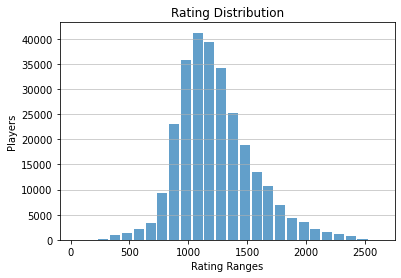

In [17]:
all_ratings = augmented_1v1['rating_p1'].append(augmented_1v1['rating_p2'])
n, bins, patches = plt.hist(x=all_ratings, bins=26, alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Rating Ranges')
plt.ylabel('Players')
plt.title('Rating Distribution')
plt.show()

### 1.5 Normalization (Z-Score, Min-Max)

Ratings are distributed asymmetricallyand. Values should be in the range 0 to 1.

**Solution:** standardize ratings considering uneven distribution (z-score)

In [31]:
try:
    normalized_1v1 = pd.read_csv('normalized_1v1.csv')
except:
    rating_mean = all_ratings.mean()
    rating_std = all_ratings.std()

    standardized_1v1 = augmented_1v1
    for i in range(len(augmented_1v1)):
        standardized_1v1.at[i, 'rating_p1'] = (augmented_1v1.at[i, 'rating_p1'] - rating_mean) / rating_std
        standardized_1v1.at[i, 'rating_p2'] = (augmented_1v1.at[i, 'rating_p2'] - rating_mean) / rating_std

    standard_ratings = standardized_1v1['rating_p1'].append(standardized_1v1['rating_p2'])
    min = standard_ratings.min()
    max = standard_ratings.max()
    abs_range = max - min

    normalized_1v1 = standardized_1v1
    for i in range(len(standardized_1v1)):
        normalized_1v1.at[i, 'rating_p1'] = (standardized_1v1.at[i, 'rating_p1'] - min) / abs_range
        normalized_1v1.at[i, 'rating_p2'] = (standardized_1v1.at[i, 'rating_p2'] - min) / abs_range

    normalized_1v1.to_csv('normalized_1v1.csv', index=False)

In [19]:
normalized_1v1.info()
normalized_1v1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140001 entries, 0 to 140000
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   match_id   140001 non-null  object 
 1   map        140001 non-null  object 
 2   rating_p1  140001 non-null  float64
 3   civ_p1     140001 non-null  object 
 4   rating_p2  140001 non-null  float64
 5   civ_p2     140001 non-null  object 
 6   winner     140001 non-null  float64
dtypes: float64(3), object(4)
memory usage: 7.5+ MB


,match_id,map,rating_p1,civ_p1,rating_p2,civ_p2,winner
0,DdP54WQtNdE0VcwM,migration,0.504802,Vikings,0.500576,Malay,1.0
1,ChnySMotXQbBOEBm,serengeti,0.488283,Burmese,0.488283,Franks,2.0
2,2gxTqXARRJB7wX3m,arabia,0.479447,Franks,0.484825,Vietnamese,1.0
3,JiobK4iAfpqwnc65,arabia,0.434883,Chinese,0.437572,Ethiopians,1.0
4,92n1BkbfROYsPb7u,arabia,0.450250,Mayans,0.436804,Vietnamese,1.0


### 1.6 One-Hot Encoding
Lastly, we also need numeric values for categorical attributes.

In [33]:
from sklearn.preprocessing import OneHotEncoder

maps_ohe = OneHotEncoder(sparse=False)
maps = maps_ohe.fit_transform(normalized_1v1['map'].values.reshape(-1, 1))
print(maps_ohe.categories_)

civs_ohe = OneHotEncoder(sparse=False)
civs_ohe.fit(normalized_1v1['civ_p1'].append(normalized_1v1['civ_p2']).values.reshape(-1, 1))

civ_p1 = civs_ohe.transform(normalized_1v1['civ_p1'].values.reshape(-1, 1))
civ_p2 = civs_ohe.transform(normalized_1v1['civ_p2'].values.reshape(-1, 1))
print(civs_ohe.categories_)

[array(['acropolis', 'arabia', 'arena', 'cenotes', 'four_lakes',
       'ghost_lake', 'gold_rush', 'golden_pit', 'golden_swamp', 'hideout',
       'islands', 'megarandom', 'migration', 'mongolia', 'nomad',
       'serengeti', 'socotra', 'team_islands', 'valley', 'water_nomad'],
      dtype=object)]
[array(['Aztecs', 'Berbers', 'Britons', 'Bulgarians', 'Burmese',
       'Byzantines', 'Celts', 'Chinese', 'Cumans', 'Ethiopians', 'Franks',
       'Goths', 'Huns', 'Incas', 'Indians', 'Italians', 'Japanese',
       'Khmer', 'Koreans', 'Lithuanians', 'Magyars', 'Malay', 'Malians',
       'Mayans', 'Mongols', 'Persians', 'Portuguese', 'Saracens', 'Slavs',
       'Spanish', 'Tatars', 'Teutons', 'Turks', 'Vietnamese', 'Vikings'],
      dtype=object)]


## 2. Linear Models

Preparing input vectors and one-hot encoding target labels.

In [21]:
X = np.concatenate((
    maps,
    normalized_1v1['rating_p1'].values.reshape(-1, 1),
    civ_p1,
    normalized_1v1['rating_p2'].values.reshape(-1, 1),
    civ_p2
    ), axis=1)

y = normalized_1v1['winner'].values - 1

Training and evaluating linear methods.

In [22]:
def winner_from_elo(p1, p2):
    return 0 if elo_to_win_prob(p1, p2) >= 0.5 else 1

In [ ]:
#@title
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

ridge = RidgeClassifier()
gnb = GaussianNB()
rand_f = RandomForestClassifier()

kfold = KFold(n_splits=10)

ridge_scores = []
gnb_scores = []
rand_f_scores = []
elo_scores = []

for train_index, test_index in kfold.split(X):
    print('\r', "Training on:", train_index[0], train_index[-1], "Testing on:", test_index[0], test_index[-1], end=' ')
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    ridge.fit(X_train, y_train)
    ridge_scores.append(ridge.score(X_test, y_test))

    gnb.fit(X_train, y_train)
    gnb_scores.append(gnb.score(X_test, y_test))

    rand_f.fit(X_train, y_train)
    rand_f_scores.append(rand_f.score(X_test, y_test))
    elo_preds = []
    for i, x in enumerate(X_test):
        elo_preds.append(winner_from_elo(x[20], x[56]))
    elo_scores.append(accuracy_score(y_test, elo_preds))

 Training on: 0 126000 Testing on: 126001 140000 

In [ ]:
print('Elo Mean:', '%.5f'%(np.mean(elo_scores)),
      'Min:', '%.5f'%(np.min(elo_scores)),
      'Max:', '%.5f'%(np.max(elo_scores)))
print('Ridge Mean:', '%.5f'%(np.mean(ridge_scores)),
      'Min:', '%.5f'%(np.min(ridge_scores)),
      'Max:', '%.5f'%(np.max(ridge_scores)))
print('GNB Mean:', '%.5f'%(np.mean(gnb_scores)),
      'Min:', '%.5f'%(np.min(gnb_scores)),
      'Max:', '%.5f'%(np.max(gnb_scores)))
print('Random Forest Mean:','%.5f'%(np.mean(rand_f_scores)),
      'Min:', '%.5f'%(np.min(rand_f_scores)),
      'Max:', '%.5f'%(np.max(rand_f_scores)))

Elo Mean: 0.51904 Min: 0.47307 Max: 0.74050
Ridge Mean: 0.54225 Min: 0.50129 Max: 0.75736
GNB Mean: 0.50243 Min: 0.49829 Max: 0.50871
Random Forest Mean: 0.50293 Min: 0.44821 Max: 0.51429


## 3. Non-Linear Model (Feed-Forward Network)

Creating a simple model.

In [23]:
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

In [24]:
class FFNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, dropout):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        lin2_dim = int(hidden_dim / 2)
        self.linear2 = nn.Linear(hidden_dim, lin2_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.linear3 = nn.Linear(lin2_dim, output_dim)
        self.dropout2 = nn.Dropout(dropout)
        self.out = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = self.dropout1(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = self.dropout2(x)
        x = F.relu(x)
        out = self.out(x)
        return out

Define training and evaluation functions.

In [25]:
loss_func = F.cross_entropy

def evaluate(model, loader):
    model.eval()
    losses = []
    accs = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            preds = model(inputs)
            loss = loss_func(preds, labels)
            acc = accuracy(preds, labels)
            losses.append(loss / len(inputs))
            accs.append(acc)

    average_loss = sum(losses) / len(losses)
    average_acc = sum(accs) / len(accs)
    return average_loss, average_acc
            
def fit(model, train_loader, test_loader, optimizer, epochs=100, print_every=10):
    model.train()
    train_losses = []
    val_losses = []
    accuracies = []

    for epoch in tqdm(range(epochs)):
        losses = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs)
            loss = loss_func(preds, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item() / len(inputs))

        val_loss, val_acc = evaluate(model, val_loader)
        epoch_loss = sum(losses) / len(losses)
        if epoch % print_every == 0 or epoch+1 == epochs:
            print()
            print(f'Epoch #{epoch + 1} ==> Train Loss:','%.5f'%(epoch_loss), 'Val Loss:','%.5f'%(val_loss), '| Val Acc:', '%.5f'%(val_acc))
        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        accuracies.append(val_acc)
    return train_losses, val_losses, accuracies

def accuracy(outs, labels):
    _, preds = torch.max(outs, dim=1)
    return (torch.tensor(torch.sum(preds==labels).item() / len(preds))) * 100

One-hot encoding targets.

In [26]:
y_one_hot = np.zeros((y.size, 2))
y_one_hot[np.arange(y.size), y.astype(int)] = 1
print(y_one_hot[:5])

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


Create datasets for training, testing and evaluating.

In [27]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1440)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=1440)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data = TensorDataset(torch.from_numpy(X_train).type(torch.float), torch.from_numpy(y_train).type(torch.long))
test_data = TensorDataset(torch.from_numpy(X_test).type(torch.float), torch.from_numpy(y_test).type(torch.long))
val_data = TensorDataset(torch.from_numpy(X_val).type(torch.float), torch.from_numpy(y_val).type(torch.long))

batch_size = 128
train_loader = DataLoader(train_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size)
val_loader = DataLoader(val_data, batch_size)

In [28]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.0)

Put the model to work.

In [ ]:
input_dim = X_train.shape[1]
output_dim = 2
hidden_dim = 256
dropout = 0.25
learning_rate = 0.05

model = FFNN(input_dim, output_dim, hidden_dim, dropout).to(device)
model.apply(init_weights)
print(model)

optim = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_losses, val_losses, accs = fit(model, train_loader, val_loader, optimizer=optim)

FFNN(
  (linear1): Linear(in_features=92, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (linear3): Linear(in_features=128, out_features=2, bias=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (out): Softmax(dim=1)
)


  1%|          | 1/100 [00:02<03:26,  2.08s/it]


Epoch #1 ==> Train Loss: 0.00542 Val Loss: 0.00550 | Val Acc: 50.82623


 11%|█         | 11/100 [00:21<02:56,  1.98s/it]


Epoch #11 ==> Train Loss: 0.00541 Val Loss: 0.00550 | Val Acc: 50.84517


 21%|██        | 21/100 [00:41<02:36,  1.98s/it]


Epoch #21 ==> Train Loss: 0.00540 Val Loss: 0.00549 | Val Acc: 52.47159


 31%|███       | 31/100 [01:01<02:16,  1.98s/it]


Epoch #31 ==> Train Loss: 0.00532 Val Loss: 0.00543 | Val Acc: 53.69555


 41%|████      | 41/100 [01:21<01:56,  1.97s/it]


Epoch #41 ==> Train Loss: 0.00525 Val Loss: 0.00537 | Val Acc: 55.00237


 51%|█████     | 51/100 [01:40<01:36,  1.97s/it]


Epoch #51 ==> Train Loss: 0.00522 Val Loss: 0.00538 | Val Acc: 54.80824


 61%|██████    | 61/100 [02:00<01:16,  1.96s/it]


Epoch #61 ==> Train Loss: 0.00520 Val Loss: 0.00538 | Val Acc: 54.74195


 71%|███████   | 71/100 [02:20<00:57,  1.97s/it]


Epoch #71 ==> Train Loss: 0.00518 Val Loss: 0.00539 | Val Acc: 54.82244


 81%|████████  | 81/100 [02:39<00:37,  1.96s/it]


Epoch #81 ==> Train Loss: 0.00516 Val Loss: 0.00541 | Val Acc: 54.85559


 91%|█████████ | 91/100 [02:59<00:17,  1.98s/it]


Epoch #91 ==> Train Loss: 0.00514 Val Loss: 0.00542 | Val Acc: 54.20454


100%|██████████| 100/100 [03:17<00:00,  1.97s/it]


Epoch #100 ==> Train Loss: 0.00513 Val Loss: 0.00544 | Val Acc: 54.95265


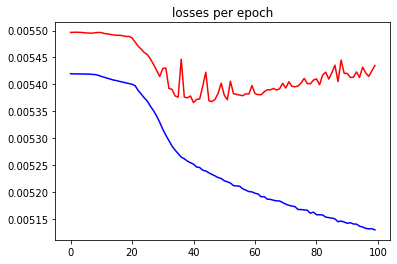

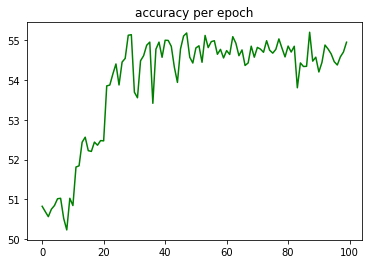

In [ ]:
plt.plot(range(len(train_losses)), train_losses, 'b', range(len(val_losses)), val_losses, 'r')
plt.title('losses per epoch')
plt.show()
plt.plot(range(len(accs)), accs, '')
plt.title('accuracy per epoch')
plt.show()

In [ ]:
test_loss, test_acc = evaluate(model, test_loader)
print(f'Test Loss:','%.5f'%(test_loss), '| Test Accuracy:', '%.5f'%(test_acc))

Test Loss: 0.00538 | Test Accuracy: 54.36637


Trying to prevent overfitting.

In [ ]:
input_dim = X_train.shape[1]
output_dim = 2
hidden_dim = 64
dropout = 0.5
learning_rate = 0.01

small_model = FFNN(input_dim, output_dim, hidden_dim, dropout).to(device)
small_model.apply(init_weights)
print(small_model)

optim = torch.optim.SGD(small_model.parameters(), lr=learning_rate)
train_losses, val_losses, accs = fit(small_model, train_loader, val_loader, optimizer=optim, epochs=200, print_every=20)

FFNN(
  (linear1): Linear(in_features=92, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (linear3): Linear(in_features=32, out_features=2, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (out): Softmax(dim=1)
)


  0%|          | 1/200 [00:01<05:02,  1.52s/it]


Epoch #1 ==> Train Loss: 0.00542 Val Loss: 0.00550 | Val Acc: 49.38684


 10%|█         | 21/200 [00:28<04:10,  1.40s/it]


Epoch #21 ==> Train Loss: 0.00542 Val Loss: 0.00550 | Val Acc: 49.63542


 20%|██        | 41/200 [00:56<03:34,  1.35s/it]


Epoch #41 ==> Train Loss: 0.00542 Val Loss: 0.00550 | Val Acc: 50.46401


 30%|███       | 61/200 [01:23<03:06,  1.35s/it]


Epoch #61 ==> Train Loss: 0.00541 Val Loss: 0.00550 | Val Acc: 51.29735


 40%|████      | 81/200 [01:51<02:44,  1.39s/it]


Epoch #81 ==> Train Loss: 0.00541 Val Loss: 0.00550 | Val Acc: 51.58854


 50%|█████     | 101/200 [02:19<02:17,  1.39s/it]


Epoch #101 ==> Train Loss: 0.00541 Val Loss: 0.00549 | Val Acc: 51.69271


 60%|██████    | 121/200 [02:46<01:47,  1.35s/it]


Epoch #121 ==> Train Loss: 0.00540 Val Loss: 0.00549 | Val Acc: 51.99810


 70%|███████   | 141/200 [03:15<01:23,  1.42s/it]


Epoch #141 ==> Train Loss: 0.00539 Val Loss: 0.00549 | Val Acc: 52.40294


 80%|████████  | 161/200 [03:45<00:57,  1.49s/it]


Epoch #161 ==> Train Loss: 0.00538 Val Loss: 0.00548 | Val Acc: 53.01373


 90%|█████████ | 181/200 [04:14<00:26,  1.41s/it]


Epoch #181 ==> Train Loss: 0.00536 Val Loss: 0.00546 | Val Acc: 53.94650


100%|██████████| 200/200 [04:40<00:00,  1.40s/it]


Epoch #200 ==> Train Loss: 0.00533 Val Loss: 0.00542 | Val Acc: 54.72538


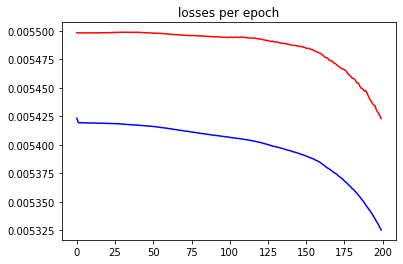

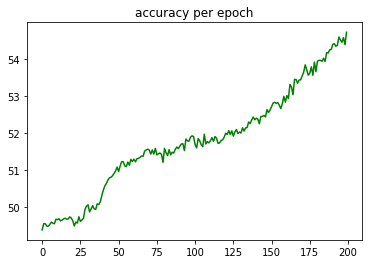

In [ ]:
plt.plot(range(len(train_losses)), train_losses, 'b', range(len(val_losses)), val_losses, 'r')
plt.title('losses per epoch')
plt.show()
plt.plot(range(len(accs)), accs, 'g')
plt.title('accuracy per epoch')
plt.show()

In [ ]:
test_loss, test_acc = evaluate(small_model, test_loader)
print(f'Test Loss:','%.5f'%(test_loss), '| Test Accuracy:', '%.5f'%(test_acc))

Test Loss: 0.00534 | Test Accuracy: 54.94041
